## Hybrid QNN with PyTorch (Convolutional network)

In [1]:
import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

algorithm_globals.random_seed = 42

In [2]:
class QuantumLayerCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):

        self._circuit = QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure_all()

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

In [3]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumLayerCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

In [4]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        
        return torch.cat((x, 1 - x), -1)

In [5]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [6]:
n_samples = 100

idx = np.append(np.where(training_data.targets == 0)[:n_samples],
                np.where(training_data.targets == 1)[:n_samples])

training_data.data = training_data.data[idx]
training_data.targets = training_data.targets[idx]

train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [7]:
n_samples = 50

idx = np.append(np.where(test_data.targets == 0)[0][:n_samples],
                np.where(test_data.targets == 1)[0][:n_samples])

test_data.data = test_data.data[idx]
test_data.targets = test_data.targets[idx]

test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

Feature batch shape: torch.Size([1, 1, 28, 28])
Labels batch shape: torch.Size([1])


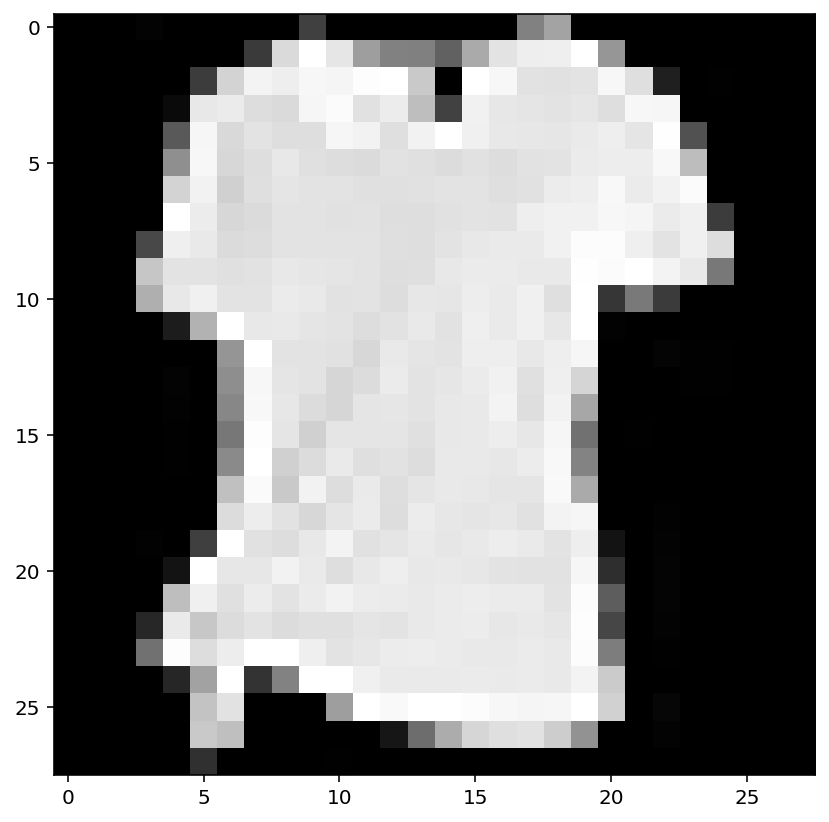

Label: 0


In [8]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]

plt.imshow(img, cmap="gray")
plt.show()

print(f"Label: {label}")

In [9]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()

for epoch in range(epochs):
    
    total_loss = []
    
    for batch_idx, (data, target) in enumerate(train_dataloader):
        
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss)/len(total_loss))
    
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(100. * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: -0.9508
Training [10%]	Loss: -0.9811
Training [15%]	Loss: -0.9832
Training [20%]	Loss: -0.9847
Training [25%]	Loss: -0.9855
Training [30%]	Loss: -0.9861
Training [35%]	Loss: -0.9870
Training [40%]	Loss: -0.9866
Training [45%]	Loss: -0.9879
Training [50%]	Loss: -0.9886
Training [55%]	Loss: -0.9888
Training [60%]	Loss: -0.9894
Training [65%]	Loss: -0.9899
Training [70%]	Loss: -0.9896
Training [75%]	Loss: -0.9901
Training [80%]	Loss: -0.9902
Training [85%]	Loss: -0.9900
Training [90%]	Loss: -0.9902
Training [95%]	Loss: -0.9907
Training [100%]	Loss: -0.9913


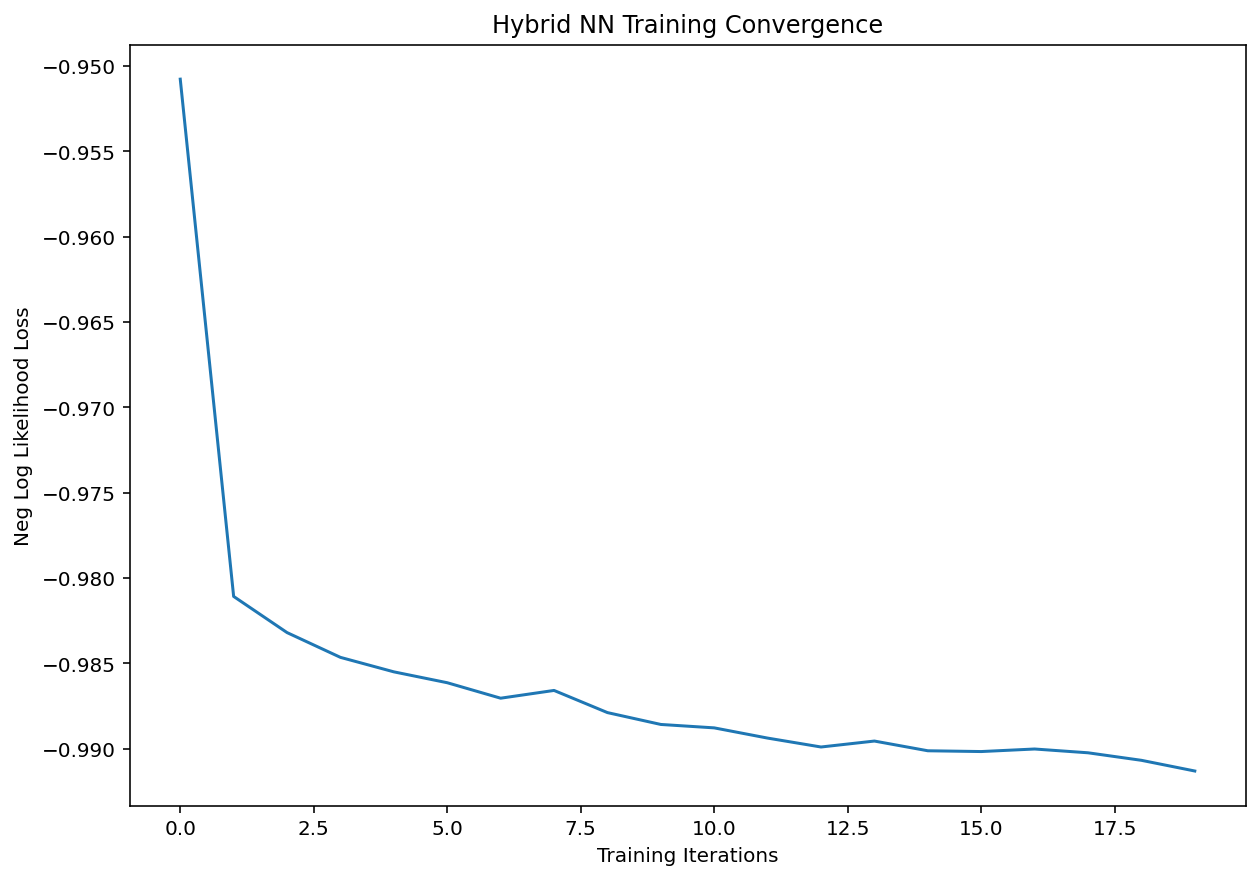

In [10]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')
plt.show()

In [11]:
model.eval()

with torch.no_grad():
    
    correct = 0
    
    for batch_idx, (data, target) in enumerate(test_dataloader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Loss: {:.4f}\nAccuracy: {:.1f}%'.format(sum(total_loss) / len(total_loss), correct / len(test_dataloader) * 100))

Loss: -0.9914
Accuracy: 100.0%


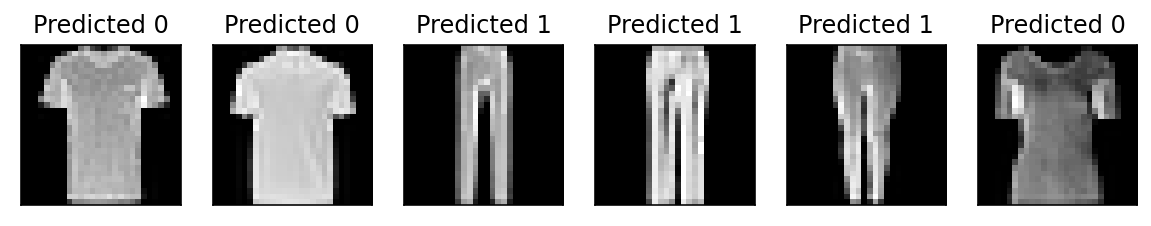

In [12]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()

with torch.no_grad():
    
    for batch_idx, (data, target) in enumerate(test_dataloader):
        
        if count == n_samples_show:
            break
        
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1

In [13]:
import qiskit.tools.jupyter
%qiskit_version_table